# ================================
# CS 559 – Group 4 – Training Data
# ================================

-------------------------------------
## 3.1 Train Data Process for Clustering
-------------------------------------

In [221]:
!pip freeze > requirements.txt

### Importing libraries and setting

In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import silhouette_score

from umap import UMAP

import joblib
import os

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set(style="whitegrid")

### Load raw training data

In [223]:
df_raw = pd.read_csv("train_data.csv")
df = df_raw.copy()

### Cleaning & feature/target split

In [224]:
corr = df.corr()["Bankrupt?"].abs().sort_values(ascending=False)
top_features = corr.index[1:61]     # skip Bankrupt? itself

X = df[top_features]
y = df["Bankrupt?"].astype(int)

# Common preprocessing: scale + Yeo-Johnson
from sklearn.pipeline import Pipeline

base_preprocess = Pipeline([
    ("scale", StandardScaler()),
    ("yeo", PowerTransformer(method="yeo-johnson"))
])

X_base = base_preprocess.fit_transform(X)

### Bankruptcy Distribution Plot

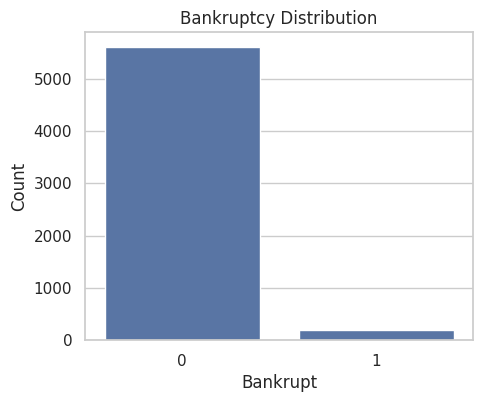

In [225]:
plt.figure(figsize=(5,4))
sns.countplot(x=df[target_col])
plt.title("Bankruptcy Distribution")
plt.xlabel("Bankrupt")
plt.ylabel("Count")
plt.show()

### Correlation Heatmap (Top Features) EDA

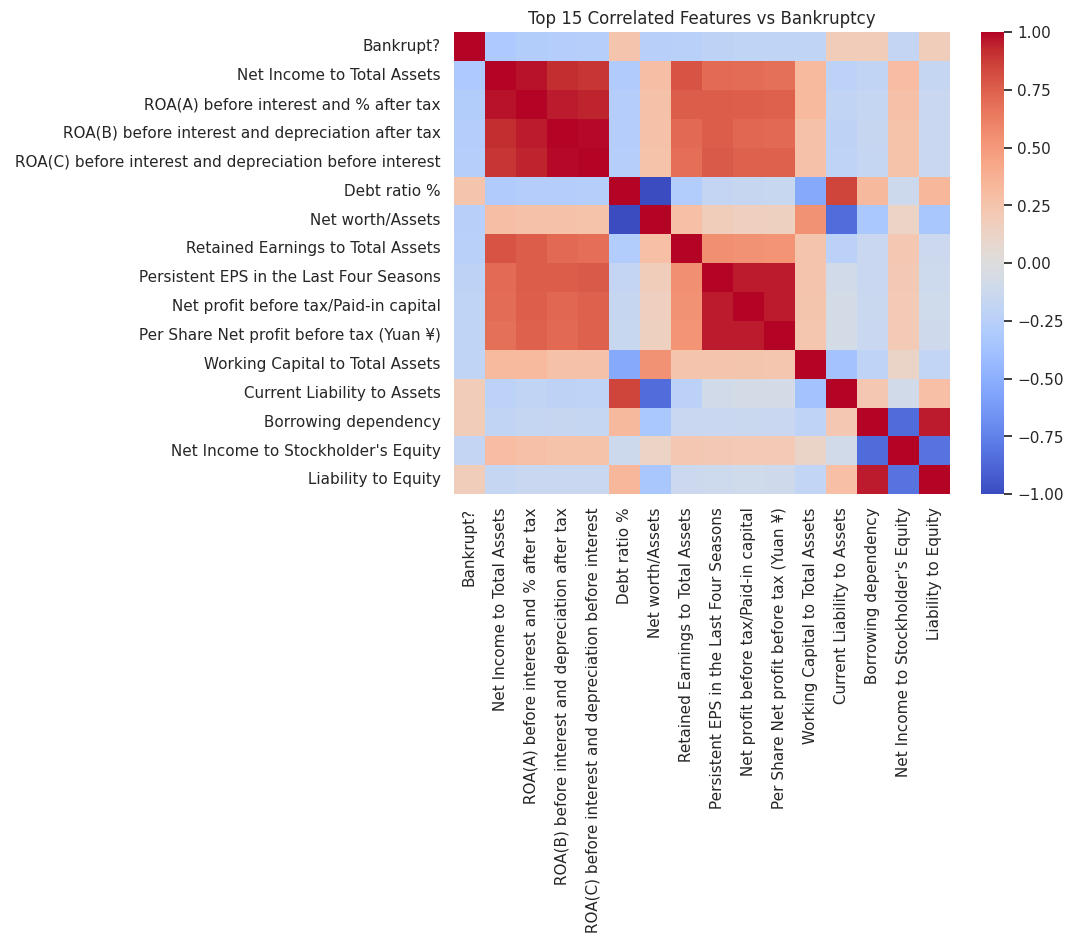

In [226]:
corr = df.drop(columns=["Index"]).corr()
top15 = corr[target_col].abs().sort_values(ascending=False).head(16).index

plt.figure(figsize=(8,6))
sns.heatmap(df[top15].corr(), annot=False, cmap="coolwarm")
plt.title("Top 15 Correlated Features vs Bankruptcy")
plt.show()

-------------------------------------
## UMAP & Preprocessing (Still Section 3.1)
-------------------------------------

### UMAP FOR CLUSTERING (20 Components)

In [227]:
umap_model = UMAP(
    n_components=20,
    n_neighbors=30,
    min_dist=0.0,
    random_state=42
)

X_umap = umap_model.fit_transform(X_base)
print("UMAP 20D Shape:", X_umap.shape)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP 20D Shape: (5807, 20)


### Choosing the Number of Clusters – Elbow Method

To justify the choice of **k = 6** clusters, we compute the K-Means inertia
(sum of squared distances to the nearest cluster center) for different values
of k and look for an "elbow" in the curve.


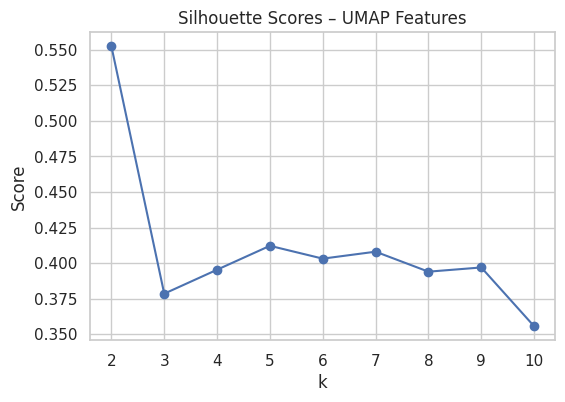

In [228]:
k_values = range(2, 11)
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels_k = km.fit_predict(X_umap)
    sil_scores.append(silhouette_score(X_umap, labels_k))

plt.figure(figsize=(6,4))
plt.plot(k_values, sil_scores, marker="o")
plt.title("Silhouette Scores – UMAP Features")
plt.xlabel("k")
plt.ylabel("Score")
plt.grid(True)
plt.show()

### Silhouette Scores for Different k

We also compute the **silhouette score** for different values of k.
Higher silhouette scores indicate better-separated, more coherent clusters.
This gives an additional check that **k = 6** is a reasonable choice.


--------------------------------------------
## 3.2 Company Characterization (Clustering)
--------------------------------------------

### Running K-Means with k=6 clusters

In [229]:
K = 6

kmeans = KMeans(
    n_clusters=K,
    random_state=42,
    n_init="auto"
)

labels = kmeans.fit_predict(X_umap)
df["cluster_id"] = labels

### 2D UMAP scatter plot with cluster colors

In [230]:
umap_2d = UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.0,
    random_state=42
)

X_umap_2d = umap_2d.fit_transform(X_base)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


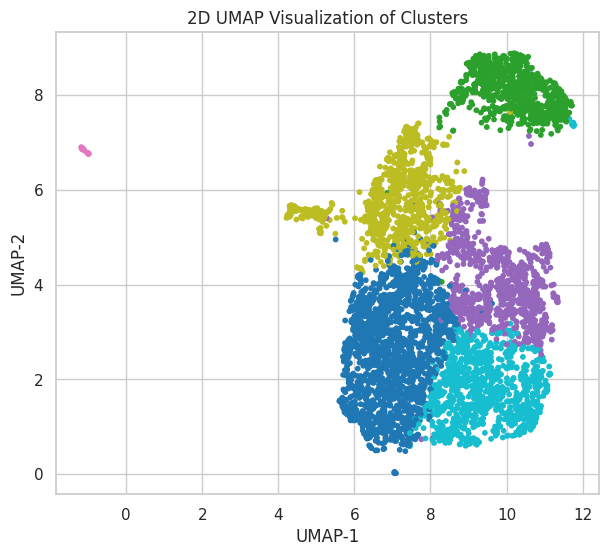

In [231]:
plt.figure(figsize=(7,6))
plt.scatter(X_umap_2d[:,0], X_umap_2d[:,1], c=df["cluster_id"], cmap="tab10", s=10)
plt.title("2D UMAP Visualization of Clusters")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

### Cluster characterization table

In [232]:
cluster_summary = (
    df.groupby("cluster_id")
      .agg(
          N_total=("Bankrupt?", "size"),
          N_bankrupt=("Bankrupt?", "sum")
      )
      .assign(bankrupt_rate=lambda x: x.N_bankrupt / x.N_total)
      .reset_index()
)

print("\n========================")
print("UMAP CLUSTER SUMMARY")
print("========================")
print(cluster_summary)


UMAP CLUSTER SUMMARY
   cluster_id  N_total  N_bankrupt  bankrupt_rate
0           0     1897          13       0.006853
1           1      900          63       0.070000
2           2      918           3       0.003268
3           3       44          15       0.340909
4           4     1010         104       0.102970
5           5     1038           0       0.000000


### Bar chart – bankruptcy rate per cluster

/tmp/ipython-input-2015170247.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


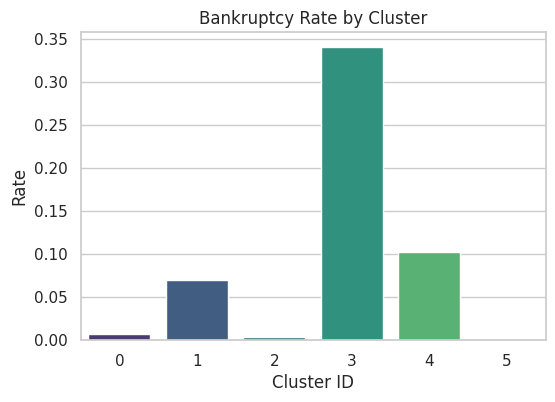

In [233]:
plt.figure(figsize=(6,4))
sns.barplot(
    x="cluster_id",
    y="bankrupt_rate",
    data=cluster_summary,
    palette="viridis"
)
plt.title("Bankruptcy Rate by Cluster")
plt.ylabel("Rate")
plt.xlabel("Cluster ID")
plt.show()

### Bar chart – cluster sizes

/tmp/ipython-input-2897202810.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


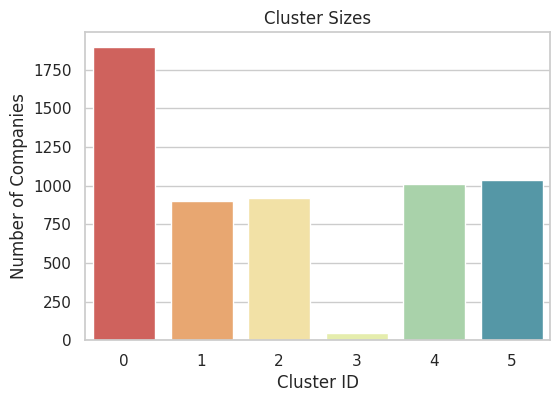

In [234]:
plt.figure(figsize=(6,4))
sns.barplot(
    x="cluster_id",
    y="N_total",
    data=cluster_summary,
    palette="Spectral"
)
plt.title("Cluster Sizes")
plt.ylabel("Number of Companies")
plt.xlabel("Cluster ID")
plt.show()

### Save Clustered Data & Per-Cluster CSVs

In [235]:
os.makedirs("data", exist_ok=True)

df.to_csv("data/train_with_clusters.csv", index=False)

for cid in sorted(df["cluster_id"].unique()):
    path = f"data/train_cluster{cid}.csv"
    df[df["cluster_id"] == cid].to_csv(path, index=False)
    print("Saved:", path)

Saved: data/train_cluster0.csv
Saved: data/train_cluster1.csv
Saved: data/train_cluster2.csv
Saved: data/train_cluster3.csv
Saved: data/train_cluster4.csv
Saved: data/train_cluster5.csv


-------------------------------------
## 3.3.1 Cluster-ID Prediction
-------------------------------------

### Prepare Data for Cluster-ID Classifier

In [236]:
X_clf = df[feature_cols]
y_clf = df["cluster_id"]

### Random Forest classifier pipeline

In [237]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_clf, y_clf)
print("Training Accuracy (RF):", rf.score(X_clf, y_clf))

Training Accuracy (RF): 1.0


### Save cluster-ID model

In [238]:
os.makedirs("models", exist_ok=True)

joblib.dump(
    {
        "scaler": scaler,
        "yeo": yeo,
        "umap_cluster": umap_model
    },
    "models/preprocessing_clustering.joblib"
)

joblib.dump(
    {
        "model": rf,
        "feature_cols": feature_cols
    },
    "models/cluster_id_model.joblib"
)

print("Saved models successfully!")

Saved models successfully!


-------------------------------------
## 3.4 Summary of Training Data Processing

In this notebook, we:

- Loaded training data and selected top 60 features based on correlation.
- Applied StandardScaler + Yeo-Johnson transformation.
- Reduced feature dimensionality using **UMAP (20 components)**.
- Performed **K-Means clustering (k = 6)** on UMAP space.
- Computed:
    - N_total per cluster
    - N_bankrupt per cluster
    - bankrupt_rate per cluster
- Visualized clusters using **2D UMAP**.
- Saved:
    - data/train_with_clusters.csv
    - data/train_cluster0.csv ... data/train_cluster5.csv
- Created clustering summary for Section 3.2.

These outputs are now ready for each subgroup to build their
bankruptcy prediction models.